## Entrega 2 - Javier Sendra

### Clasificación de emails (Spam o Ham)

Importar librerias

In [1]:
import pandas as pd
import re
import string
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, caonfusion_matrix
from sklearn.model_selection import train_test_split

### 1. Lectura de Fichero

In [2]:
data = pd.read_csv("spam.csv",sep = ",")

In [3]:
data

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [4]:
data["spam"] = data.label
data = data[['text', 'spam']]

In [5]:
#Visualize dataset
# Vamos a ver cual es el mensaje más popular entre spam y ham
data.groupby('spam').describe()

text                                                               
     count unique                                                top freq
spam                                                                     
ham   4825   4516                             Sorry, I'll call later   30
spam   747    642  Please call our customer service representativ...    4

In [6]:
# Vamos a ver cual es el email con mas caracteres
data['length'] = data['text'].apply(len)
data['length'].max()

910

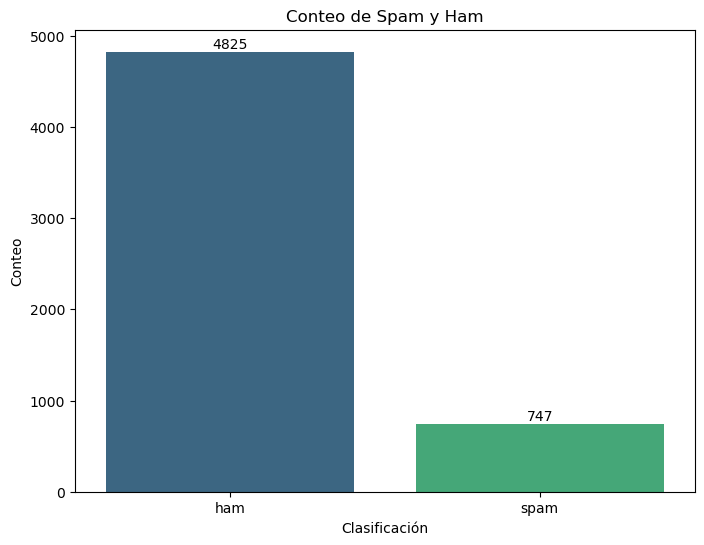

In [7]:
# Cuenta el número de ocurrencias de cada categoría en la columna 'Spam'.
spam_counts = data['spam'].value_counts()

# Crea un gráfico de barras con barras separadas para 'spam' y 'ham'.
plt.figure(figsize=(8, 6))
sns.countplot(x='spam', data=data, palette='viridis')

# Etiqueta y título del gráfico.
plt.xlabel('Clasificación')
plt.ylabel('Conteo')
plt.title('Conteo de Spam y Ham')

# Añade etiquetas a las barras con el número exacto de ocurrencias.
for i, count in enumerate(spam_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

# Muestra el gráfico.
plt.show()

Podemos ver como tenemos mas emails de tipo ham que Spam

220
46


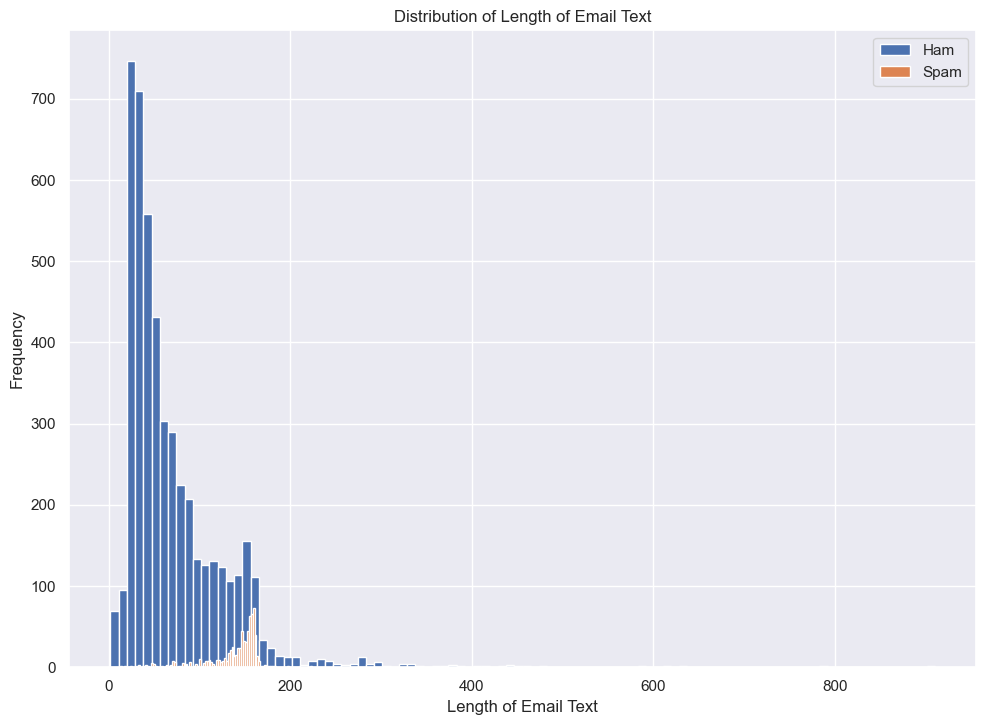

In [8]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ham_messages_length =  data[data['spam']=="ham"] 
spam_messages_length =  data[data['spam']=="spam"]

ham_messages_length['length'].plot(bins=100, kind='hist',label = 'Ham') 
spam_messages_length['length'].plot(bins=100, kind='hist',label = 'Spam') 

plt.title('Distribution of Length of Email Text')
plt.xlabel('Length of Email Text')
plt.legend()

data[data['spam']== "ham"].text.values

#Maximo de Palabras en un email por clasificacion ham y spam
ham_words_length = [len(word_tokenize(title)) for title in data[data['spam']=="ham"].text.values]
spam_words_length = [len(word_tokenize(title)) for title in data[data['spam']=="spam"].text.values]
print(max(ham_words_length))
print(max(spam_words_length))

Podemos ver como los emails clasificados como ham, tienen muchos más caracteres.

### 2. Realizar Preprocesamiento

In [9]:
strings= data.text
corpus = strings.to_list()

In [10]:
def limpiar_texto(texto):
    if not isinstance(texto, str):
        raise ValueError("El argumento 'texto' debe ser una cadena de texto.")
    
    # Eliminar caracteres especiales y números
    texto = re.sub(r'[^a-zA-Z\s]', '', texto)
    
    # Convertir a minúsculas
    texto = texto.lower()
    
    # Tokenizar el texto
    tokens = word_tokenize(texto)
    
    # Eliminar stop words
    stop_words = set(stopwords.words('english'))
    tokens_filtrados = [word for word in tokens if word not in stop_words]
    
    # Unir tokens nuevamente en un string
    texto_limpiado = ' '.join(tokens_filtrados)
    
    return texto_limpiado

def limpiar_corpus(corpus):
    corpus_limpiado = []
    
    for email in corpus:
        try:
            email_limpiado = limpiar_texto(email)
            corpus_limpiado.append(email_limpiado)
        except ValueError as e:
            print(f"Error: {e}")
            corpus_limpiado.append('error')
    
    return corpus_limpiado

# Llamar a la función para limpiar el corpus
corpus_limpiado = limpiar_corpus(corpus)

# Imprimir resultados
for email, email_limpiado in zip(corpus, corpus_limpiado):
    print(f"Email original: {email}\nEmail limpiado: {email_limpiado}\n")


Email original: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Email limpiado: go jurong point crazy available bugis n great world la e buffet cine got amore wat

Email original: Ok lar... Joking wif u oni...
Email limpiado: ok lar joking wif u oni

Email original: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Email limpiado: free entry wkly comp win fa cup final tkts st may text fa receive entry questionstd txt ratetcs apply overs

Email original: U dun say so early hor... U c already then say...
Email limpiado: u dun say early hor u c already say

Email original: Nah I don't think he goes to usf, he lives around here though
Email limpiado: nah dont think goes usf lives around though

Email original: FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! X

In [11]:
data['corpus_limpiado'] = data['text'].apply(lambda x: limpiar_texto(x))

Ham Mean: 0.267
Spam Mean: 0.203


/var/folders/2x/kdfl2g5n1gjg7cnrl8nr1v980000gn/T/ipykernel_23214/2097375675.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ham_stopwords, norm_hist = True, label = 'ham')
/var/folders/2x/kdfl2g5n1gjg7cnrl8nr1v980000gn/T/ipykernel_23214/2097375675.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns

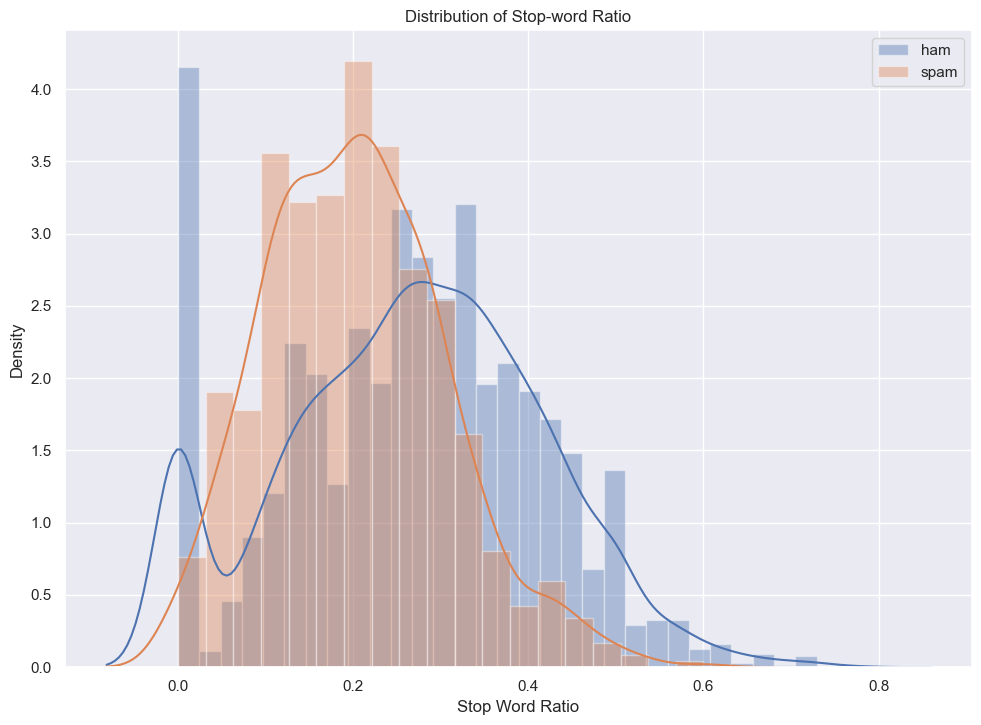

In [12]:
#Checking ratio of stop words

stop_words = set(stopwords.words('english'))
    
    
def stop_words_ratio(x):
    num_total_words = 0
    num_stop_words = 0
    for word in word_tokenize(x):
        if word in stop_words:
            num_stop_words += 1
        num_total_words += 1 
    return num_stop_words/num_total_words


ham_stopwords = data[data['spam']=="ham"].text.apply(stop_words_ratio)
spam_stopwords = data[data['spam']=="spam"].text.apply(stop_words_ratio)


sns.distplot(ham_stopwords, norm_hist = True, label = 'ham')
sns.distplot(spam_stopwords,  label = 'spam')

print('Ham Mean: {:.3f}'.format(ham_stopwords.values.mean()))
print('Spam Mean: {:.3f}'.format(spam_stopwords.values.mean()))
plt.title('Distribution of Stop-word Ratio')
plt.xlabel('Stop Word Ratio')
plt.legend()

Con este gráfico podemos ver como tanto los emails ham como spam tiene texto con stopwords. Emails de Spam tienen una media de 0.203 stopwords, y los ham emails tienen una media de 0.267. Aunque los ham emails tengan una media superior, los spam emails tienen una media más concentrada por cada email.

### 3. Matriz TF-IDF

In [13]:

# Crear el objeto TfidfVectorizer
vectorizer = TfidfVectorizer()

# Aplicar el vectorizador al corpus limpiado
matriz_tfidf = vectorizer.fit_transform(corpus_limpiado)

# Obtener las características (palabras) en el conjunto de datos
features = vectorizer.get_feature_names_out()

# Convertir la matriz TF-IDF a un array de numpy para visualizar mejor
matriz_tfidf_array = matriz_tfidf.toarray()

# Crear un DataFrame para visualizar la matriz TF-IDF
df_tfidf = pd.DataFrame(matriz_tfidf_array, columns=features)

print(df_tfidf)


       aa  aah  aaniye  aaooooright  aathilove  aathiwhere   ab  abbey  \
0     0.0  0.0     0.0          0.0        0.0         0.0  0.0    0.0   
1     0.0  0.0     0.0          0.0        0.0         0.0  0.0    0.0   
2     0.0  0.0     0.0          0.0        0.0         0.0  0.0    0.0   
3     0.0  0.0     0.0          0.0        0.0         0.0  0.0    0.0   
4     0.0  0.0     0.0          0.0        0.0         0.0  0.0    0.0   
...   ...  ...     ...          ...        ...         ...  ...    ...   
5567  0.0  0.0     0.0          0.0        0.0         0.0  0.0    0.0   
5568  0.0  0.0     0.0          0.0        0.0         0.0  0.0    0.0   
5569  0.0  0.0     0.0          0.0        0.0         0.0  0.0    0.0   
5570  0.0  0.0     0.0          0.0        0.0         0.0  0.0    0.0   
5571  0.0  0.0     0.0          0.0        0.0         0.0  0.0    0.0   

      abdomen  abeg  ...  zeros   zf  zhong  zindgi  zoe  zogtorius  zoom  \
0         0.0   0.0  ...    0.0  0

In [14]:

vectorizer = TfidfVectorizer(max_features = 20)

X_tfidf = vectorizer.fit_transform(corpus_limpiado)

print("Vocabulario TF-IDF:", vectorizer.get_feature_names_out())

tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out(), index=corpus_limpiado)

Vocabulario TF-IDF: ['call' 'come' 'day' 'dont' 'free' 'get' 'go' 'good' 'got' 'ill' 'im'
 'know' 'like' 'love' 'ltgt' 'ok' 'send' 'time' 'ur' 'want']


#### Matriz BOW

In [15]:

vectorizer = CountVectorizer(max_features= 20)

X_bow = vectorizer.fit_transform(corpus_limpiado)

print("Vocabulario BoW:", vectorizer.get_feature_names_out())

df = pd.DataFrame(X_bow.toarray(), columns=vectorizer.get_feature_names_out(), index=corpus_limpiado)

Vocabulario BoW: ['call' 'come' 'day' 'dont' 'free' 'get' 'go' 'good' 'got' 'ill' 'im'
 'know' 'like' 'love' 'ltgt' 'ok' 'send' 'time' 'ur' 'want']


### 4. Division de subconjunto por entrenamiento y evaluacion

In [17]:
# Divide el DataFrame en entrenamiento y prueba
train_df, test_df = train_test_split(
    data,                   # DataFrame completo
    test_size=0.2,        # Porcentaje de datos para el conjunto de prueba
    random_state=42       # Semilla para reproducibilidad
)


### 5.  Realizar modelos de entrenamiento y obtener resultados de accuracy de la clasificación, así como las matrices de confusión para los tres modelos.

#### Naive Bayes

In [18]:
# Crear el modelo usando un pipeline con TF-IDF y el clasificador Naive Bayes o Bayesiano Ingenuo
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

# Entrenar el modelo con el conjunto de entrenamiento
model.fit(train_df['corpus_limpiado'], train_df['spam'])

# Realizar predicciones en el conjunto de evaluación
predictions = model.predict(test_df['corpus_limpiado'])


#### Evaluacion del modelo

In [19]:
# Evaluar el rendimiento del modelo
accuracy = accuracy_score(test_df['spam'], predictions)
conf_matrix = confusion_matrix(test_df['spam'], predictions)
classification_rep = classification_report(test_df['spam'], predictions)

# Mostrar los resultados
print(f'Accuracy: {accuracy:.2f}')
print('\nConfusion Matrix:') 
print(conf_matrix)
print('\nClassification Report:')
print(classification_rep)

Accuracy: 0.97

Confusion Matrix:
[[965   0]
 [ 35 115]]

Classification Report:
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       965
        spam       1.00      0.77      0.87       150

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.93      1115
weighted avg       0.97      0.97      0.97      1115



Mayor precisión en la clasificación de "ham" (97%). Buen recall para "ham" (100%). Desventajas: Recall relativamente bajo para "spam" (77%).

#### Máquina de vectores de Soporte

In [20]:
# Crear el modelo usando un pipeline con TF-IDF y el clasificador SVM
model_svm = make_pipeline(TfidfVectorizer(), SVC())

# Entrenar el modelo con el conjunto de entrenamiento
model_svm.fit(train_df['corpus_limpiado'], train_df['spam'])

# Realizar predicciones en el conjunto de evaluación
predictions_svm = model_svm.predict(test_df['corpus_limpiado'])


#### Evaluacion del Modelo SVM

In [21]:
# Evaluar el rendimiento del modelo
accuracy_svm = accuracy_score(test_df['spam'], predictions_svm)
conf_matrix_svm = confusion_matrix(test_df['spam'], predictions_svm)
classification_rep_svm = classification_report(test_df['spam'], predictions_svm)

# Mostrar los resultados
print(f'Accuracy (SVM): {accuracy_svm:.2f}')
print('\nConfusion Matrix (SVM):')
print(conf_matrix_svm)
print('\nClassification Report (SVM):')
print(classification_rep_svm)

Accuracy (SVM): 0.97

Confusion Matrix (SVM):
[[963   2]
 [ 26 124]]

Classification Report (SVM):
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99       965
        spam       0.98      0.83      0.90       150

    accuracy                           0.97      1115
   macro avg       0.98      0.91      0.94      1115
weighted avg       0.98      0.97      0.97      1115



Precisión elevada para ambas clases (97%). Buen recall para "ham" (100%). Tiene un Recall ligeramente más alto para "spam" en comparación con Naive Bayes.

#### Modelo basado en Árboles de decisión

In [22]:
# Supongamos que tienes un DataFrame llamado train_df con las columnas 'corpus_limpiado' y 'spam'
# Asegúrate de tener estas columnas en tu DataFrame antes de ejecutar el código

# Crear el modelo usando un pipeline con TF-IDF y el clasificador de árbol de decisión
model_tree = make_pipeline(TfidfVectorizer(), DecisionTreeClassifier(random_state=42))

# Entrenar el modelo con el conjunto de entrenamiento
model_tree.fit(train_df['corpus_limpiado'], train_df['spam'])

# Realizar predicciones en el conjunto de evaluación
predictions_tree = model_tree.predict(test_df['corpus_limpiado'])


#### Evaluacion Arboles de decision

In [23]:
# Evaluar el rendimiento del modelo
accuracy_tree = accuracy_score(test_df['spam'], predictions_tree)
conf_matrix_tree = confusion_matrix(test_df['spam'], predictions_tree)
classification_rep_tree = classification_report(test_df['spam'], predictions_tree)

# Mostrar los resultados
print(f'Accuracy (Decision Tree): {accuracy_tree:.2f}')
print('\nConfusion Matrix (Decision Tree):')
print(conf_matrix_tree)
print('\nClassification Report (Decision Tree):')
print(classification_rep_tree)

Accuracy (Decision Tree): 0.95

Confusion Matrix (Decision Tree):
[[940  25]
 [ 36 114]]

Classification Report (Decision Tree):
              precision    recall  f1-score   support

         ham       0.96      0.97      0.97       965
        spam       0.82      0.76      0.79       150

    accuracy                           0.95      1115
   macro avg       0.89      0.87      0.88      1115
weighted avg       0.94      0.95      0.94      1115



Precisión alta para "ham" (96%). Recall decente para "ham" y "spam". Desventajas: Precisión y recall más bajos para "spam" en comparación con Naive Bayes y SVM.

#### Modelo predictivo de como avanzaría nuestros datos entrenados y nuestro datos de evaluación
from  matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])

plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')

plt.ylabel('accuracy')

plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')

plt.grid()

plt.show()

### Conclusión

En general, los tres modelos tienen un rendimiento sólido, pero si la identificación precisa de "spam" es una prioridad, podrías inclinarte hacia el modelo SVM, ya que tiene un recall más alto para "spam". Por otro lado, buscando un equilibrio entre precisión y recall para ambas clases, SVM también es una opción fuerte.

Hay que tener en cuenta el contexto específico para que vamos a utilizar estos datos, y cómo se valoran los falsos positivos y los falsos negativos, como es en nuestro caso tras analizar cuales son spam y cuales son ham. En algunos escenarios, puede ser más crítico minimizar los falsos positivos (clasificar algo como "spam" cuando no lo es) o minimizar los falsos negativos (clasificar algo como "ham" cuando es "spam").

#### Al entrenar primero el modelo y despues hacer el analsis de modelos. El modelo con mayor precision has sido también el de SVM. Exactamente, SVM Accuracy: 0.9766816143497757 (ligeramente mas alto)


### 6. ¿Tiene influencia en el resultado final el número máximo de features a utilizar? 

#### Nuevos features para mi tabla de Naive Bayes

In [26]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

# Valores para max_features
max_features_values = [1000, 10000]

for max_features in max_features_values:
    # Crea el modelo usando un pipeline con TF-IDF y el clasificador Naive Bayes
    model = make_pipeline(TfidfVectorizer(max_features=max_features), MultinomialNB())

    # Entrena el modelo con el conjunto de entrenamiento
    model.fit(train_df['corpus_limpiado'], train_df['spam'])

    # Realiza predicciones en el conjunto de evaluación
    predictions = model.predict(test_df['corpus_limpiado'])

    # Mide la precisión del modelo
    accuracy = accuracy_score(test_df['spam'], predictions)
    print(f'Max Features: {max_features}, Accuracy: {accuracy:.2f}')

Max Features: 1000, Accuracy: 0.98
Max Features: 10000, Accuracy: 0.97


#### Nuevos features para mi tabla de SVM


In [28]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

# Define diferentes valores para max_features
max_features_values = [1000, 10000]

for max_features in max_features_values:
    # Crea el modelo usando un pipeline con TF-IDF y el clasificador SVM
    model = make_pipeline(TfidfVectorizer(max_features=max_features), SVC())

    # Entrena el modelo con el conjunto de entrenamiento
    model.fit(train_df['corpus_limpiado'], train_df['spam'])

    # Realiza predicciones en el conjunto de evaluación
    predictions = model.predict(test_df['corpus_limpiado'])

    # Mide la precisión del modelo
    accuracy = accuracy_score(test_df['spam'], predictions)
    print(f'Max Features: {max_features}, Accuracy: {accuracy:.2f}')


Max Features: 1000, Accuracy: 0.98
Max Features: 10000, Accuracy: 0.97


#### Nuevos features para mi tabla de Árboles de Decisión

In [30]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

# Define diferentes valores para max_features
max_features_values = [1000, 5000, 10000]

for max_features in max_features_values:
    # Crea el modelo usando un pipeline con TF-IDF y el clasificador Decision Tree
    model = make_pipeline(TfidfVectorizer(max_features=max_features), DecisionTreeClassifier())

    # Entrena el modelo con el conjunto de entrenamiento
    model.fit(train_df['corpus_limpiado'], train_df['spam'])

    # Realiza predicciones en el conjunto de evaluación
    predictions = model.predict(test_df['corpus_limpiado'])

    # Mide la precisión del modelo
    accuracy = accuracy_score(test_df['spam'], predictions)
    print(f'Max Features: {max_features}, Accuracy: {accuracy:.2f}')


Max Features: 1000, Accuracy: 0.96
Max Features: 5000, Accuracy: 0.95
Max Features: 10000, Accuracy: 0.96


#### Conclusion: podemos ver como en los tres modelos analíticos el porcentaje de precisión ha aumentado en medida de las tener un numero de features diferentes.

### 7. Comente los resultados obtenidos.